In [1]:

import recordlinkage as rl
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections
from sklearn.model_selection import train_test_split, KFold
import generator_dataset_epbrn as gd
import plots as pl
import generate_links as links
import models as mod

In [2]:
def load_file(path):
    df = pd.read_csv(path, index_col = "rec_id")
    return df

def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')   
    c.string('phone_number', 'phone_number', method='levenshtein', label='y_phone_leven') 
    c.string('phone_number', 'phone_number', method='jarowinkler', label='y_phone_jaro')
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df, train_true_links):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)

    train_false_links = links.generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

def generate_train_sets(df_train):
    ## TRAIN SET CONSTRUCTION

    train_true_links = links.generate_true_links(df_train)

    print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

    # Preprocess train set
    df_train['postcode'] = df_train['postcode'].astype(str)

    # Final train feature vectors and labels
    X_train, y_train = generate_train_X_y(df_train, train_true_links)
    print("Finished building X_train, y_train")

    return X_train, y_train

def block_test_sets(df_test):
    # Blocking Criteria: declare non-match of all of the below fields disagree
    # Import
    test_true_links = links.generate_true_links(df_test)
    leng_test_true_links = len(test_true_links)

    print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

    print("BLOCKING PERFORMANCE:")
    blocking_fields = ["given_name", "surname", "postcode","phone_number"]
    all_candidate_pairs = []
    for field in blocking_fields:
        block = rl.Index()
        block.block(on=field)
        candidates = block.index(df_test)
        detects = blocking_performance(candidates, test_true_links, df_test)
        all_candidate_pairs = candidates.union(all_candidate_pairs)
        print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
            detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
            str(leng_test_true_links-detects))

    detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
    print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
        detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
            str(leng_test_true_links-detects))
            
    return all_candidate_pairs

def generate_test_sets(df_test, all_candidate_pairs):
    ## TEST SET CONSTRUCTION

    # Preprocess test set
    print("Processing test set...")
    print("Preprocess...")
    df_test['postcode'] = df_test['postcode'].astype(str)

    # Test feature vectors and labels construction
    print("Extract feature vectors...")
    df_X_test = extract_features(df_test, all_candidate_pairs)
    vectors = df_X_test.values.tolist()
    labels = [0]*len(vectors)
    feature_index = df_X_test.index
    for i in range(0, len(feature_index)):
        if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
            labels[i] = 1
    X_test, y_test = shuffle(vectors, labels, random_state=0)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print("Count labels of y_test:",collections.Counter(y_test))
    print("Finished building X_test, y_test")
    return X_test, y_test

In [3]:
def train_test_models(X_train, y_train, X_test, y_test, models, param_range):
    ## BASE LEARNERS CLASSIFICATION AND EVALUATION
    # Choose model
    print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
    #models = {'svm': ['linear','rbf'], 'lg': ['l1','l2'], 'nn': ['relu','logistic']}
    #modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN

    df_precision = pd.DataFrame()
    df_sensitivity = pd.DataFrame()
    df_fscore = pd.DataFrame()
    df_nb_false = pd.DataFrame()
    
    df_precision["param"] = param_range
    df_sensitivity["param"] = param_range
    df_fscore["param"] = param_range
    df_nb_false["param"] = param_range

    for i in models:
        for j in models[i]:
            print("Model:",i,", Param_1:",j, ", tuning range:", param_range)
            precision = []
            sensitivity = []
            Fscore = []
            nb_false = []

            for modelparam in param_range:
                md = mod.train_model(i, modelparam, X_train, y_train, j)
                final_result = mod.classify(md, X_test)
                final_eval = mod.evaluation(y_test, final_result)
                precision += [final_eval['precision']]
                sensitivity += [final_eval['sensitivity']]
                Fscore += [final_eval['F-score']]
                nb_false  += [final_eval['no_false']]
                
            df_precision[i + "-" + j] = precision
            df_sensitivity[i + "-" + j] = sensitivity
            df_fscore[i + "-" + j] = Fscore
            df_nb_false[i + "-" + j] = nb_false

            #print("No_false:",nb_false,"\n")
            #print("Precision:",precision,"\n")
            #print("Sensitivity:",sensitivity,"\n")
            #print("F-score:", Fscore,"\n")
        
    return df_precision, df_sensitivity, df_fscore, df_nb_false

def bagging_model(X_train, y_train, X_test, y_test, df_bests):
    ## ENSEMBLE CLASSIFICATION AND EVALUATION

    print("BAGGING PERFORMANCE:\n")
    
    df_bagging = pd.DataFrame(columns = ['model', 'no_false', 'confusion_matrix', 'precision', 'sensitivity', 
                                            'no_links', 'F-score', 'true_pos', 'true_neg', 'false_pos', 'false_neg'])

    nFold = 10
    kf = KFold(n_splits=nFold)
    
    model_raw_score = [0]*3
    model_binary_score = [0]*3
    model_i = 0
        
    for model_i in range(len(df_bests)):

        modeltype = df_bests.loc[model_i, "model"]
        modeltype_2 = df_bests.loc[model_i, "modeltype"]
        modelparam = df_bests.loc[model_i, "param"]
        
        print(modeltype, "per fold:")
        iFold = 0
        result_fold = [0]*nFold
        final_eval_fold = [0]*nFold

        for train_index, valid_index in kf.split(X_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            md =  mod.train_model(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
            result_fold[iFold] = mod.classify(md, X_test)
            final_eval_fold[iFold] = mod.evaluation(y_test, result_fold[iFold])
            print("Fold", str(iFold), final_eval_fold[iFold])
            iFold = iFold + 1

        bagging_raw_score = np.average(result_fold, axis=0)
        bagging_binary_score  = np.copy(bagging_raw_score)
        bagging_binary_score[bagging_binary_score > 0.5] = 1
        bagging_binary_score[bagging_binary_score <= 0.5] = 0
        bagging_eval = mod.evaluation(y_test, bagging_binary_score)
        print(modeltype, "bagging:", bagging_eval)
        print('')
        model_raw_score[model_i] = bagging_raw_score
        model_binary_score[model_i] = bagging_binary_score

        model = modeltype + " bag"
        df_bagging.loc[model_i] =  [model] + [v for _, v in bagging_eval.items()]

    thres = .99

    print("STACKING PERFORMANCE:\n")
    stack_raw_score = np.average(model_raw_score, axis=0)
    stack_binary_score = np.copy(stack_raw_score)
    stack_binary_score[stack_binary_score > thres] = 1
    stack_binary_score[stack_binary_score <= thres] = 0
    stacking_eval = mod.evaluation(y_test, stack_binary_score)
    print(stacking_eval)

    model = "stack bagging" + modeltype_2 + " " + str(modelparam)
    df_bagging.loc[len(df_bagging)] =  [model] + [v for _, v in stacking_eval.items()]

    return df_bagging


In [4]:
PATH_FILES =  "../data/ePBRN/"
PATH_IMAGES =  "../images/"
PATH_OUTPUT =  "../output/"

np.random.seed(42)

use_new_inputs = True

#####################################################################################################
if use_new_inputs is False:
            
    ## if using their files: 1
    trainset = PATH_FILES + 'ePBRN_F_dup.csv' 
    testset = PATH_FILES + 'ePBRN_D_dup.csv'
    file_version = "_1_"
else:
    ## if generating new files: 2
    trainset = PATH_FILES + 'ePBRN_F_rep.csv' 
    testset = PATH_FILES + 'ePBRN_D_rep.csv'
    file_version = "_2_"
#####################################################################################################

df_train = load_file(trainset)
df_test = load_file(testset)

In [5]:
df_train.isnull().sum()

given_name        574
surname           582
street_number      11
address_1         569
address_2        8514
suburb            164
postcode            9
state            1443
phone_number        6
day              1432
month            1438
year             1453
match_id            4
dtype: int64

In [6]:
X_train, y_train = generate_train_sets(df_train)
all_candidate_pairs = block_test_sets(df_test)
X_test, y_test = generate_test_sets(df_test, all_candidate_pairs)

Train set size: 14093 , number of matched pairs:  3230
Finished building X_train, y_train
Test set size: 11743 , number of matched pairs:  2683
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 257710 , detected  1646 /2683 true matched pairs, missed 1037
Number of pairs of matched surname: 33894 , detected  1592 /2683 true matched pairs, missed 1091
Number of pairs of matched postcode: 78856 , detected  2526 /2683 true matched pairs, missed 157
Number of pairs of matched phone_number: 174873 , detected  2411 /2683 true matched pairs, missed 272
Number of pairs of at least 1 field matched: 538482 , detected  2677 /2683 true matched pairs, missed 6
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 535805, 1: 2677})
Finished building X_test, y_test


In [7]:
#Models to evaluate
models = {'svm': ['linear','rbf'], 'lg': ['l1','l2'], 'nn': ['relu','logistic']}
param_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN

df_precision, df_sensitivity, df_fscore, df_nb_false = train_test_models(X_train, y_train, X_test, y_test, models, param_range)

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: linear , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
Model: svm , Param_1: rbf , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
Model: lg , Param_1: l1 , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
Model: lg , Param_1: l2 , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
Model: nn , Param_1: relu , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]


c:\Users\admin\Desktop\GT Masters\22 Fall\CSE 6250\Project\CSE6250_BDH_Project\CSE6250_BDH_Project\code\models.py:98: RuntimeWarning: invalid value encountered in long_scalars
  precision = count_true_pos / (count_true_pos + count_false_pos)


Model: nn , Param_1: logistic , tuning range: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]


c:\Users\admin\Desktop\GT Masters\22 Fall\CSE 6250\Project\CSE6250_BDH_Project\CSE6250_BDH_Project\code\models.py:98: RuntimeWarning: invalid value encountered in long_scalars
  precision = count_true_pos / (count_true_pos + count_false_pos)


c:\Users\admin\Desktop\GT Masters\22 Fall\CSE 6250\Project\CSE6250_BDH_Project\CSE6250_BDH_Project\code\plots.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation="vertical")


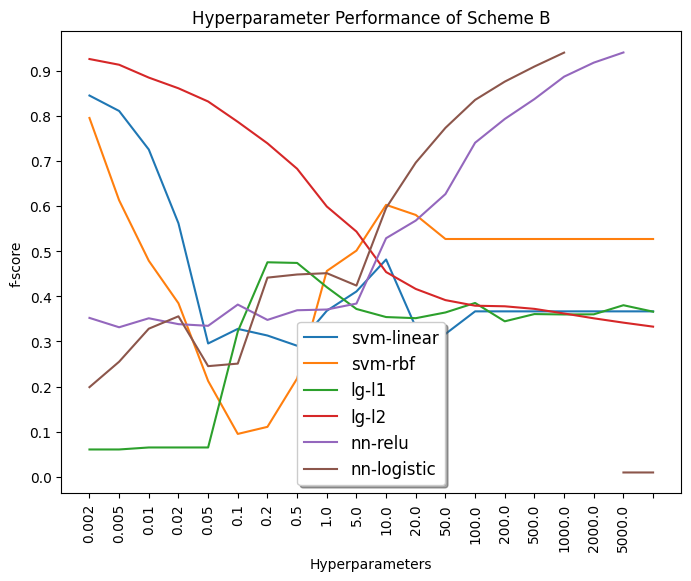

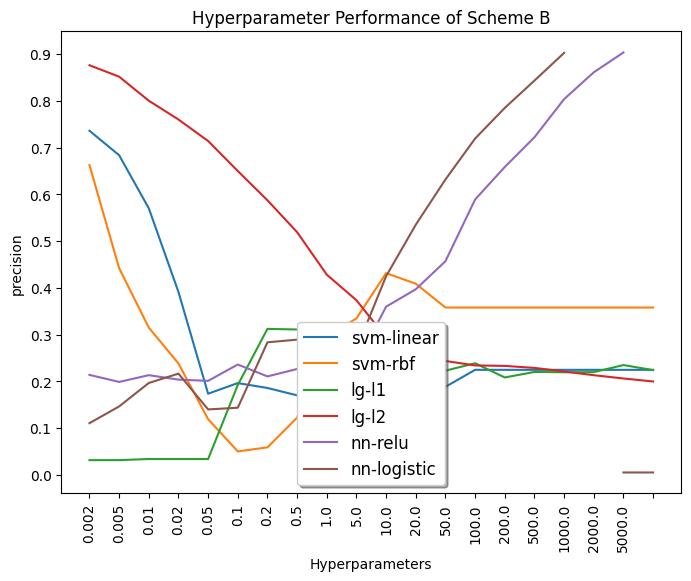

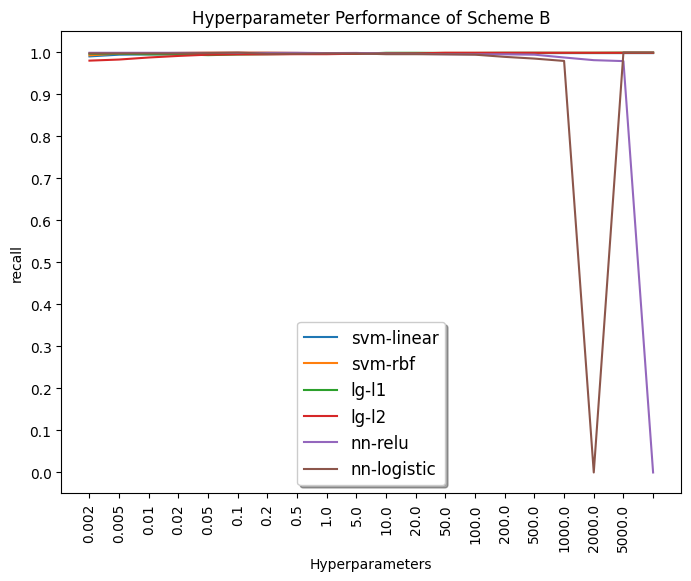

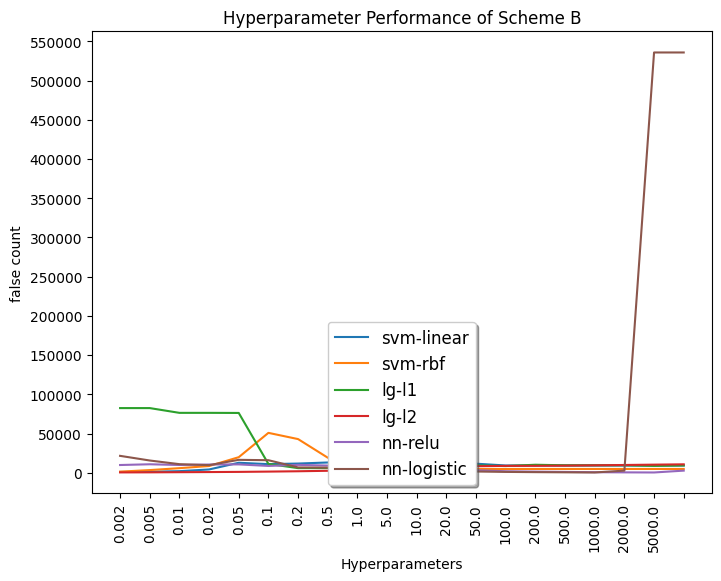

In [9]:

pl.show_plot(df_fscore, "Hyperparameter Performance of Scheme B", "f-score", "schemeB" + file_version + "fscore.png", PATH_IMAGES)
pl.show_plot(df_precision, "Hyperparameter Performance of Scheme B", "precision", "schemeB" + file_version + "precision.png", PATH_IMAGES)
pl.show_plot(df_sensitivity, "Hyperparameter Performance of Scheme B", "recall", "schemeB" + file_version + "recall.png", PATH_IMAGES)
pl.show_plot(df_nb_false, "Hyperparameter Performance of Scheme B", "false count", "schemeB" + file_version + "falses.png", PATH_IMAGES)
df_fscore.to_csv(PATH_OUTPUT + 'schemeB' + file_version + 'fscore_data.csv')

In [10]:
#####################################################################################################
## if using their files    
#lst = [['svm-rbf', 0.001], ['nn-relu', 2000], ['lg-l2', 0.005]]
#df_bestmodels = mod.get_scores(df_fscore, df_precision, df_sensitivity, df_nb_false, lst)

## if generating new files
df_bestmodels = mod.get_best_model(df_fscore, df_precision, df_sensitivity, df_nb_false, models)
#####################################################################################################

df_bestmodels.to_csv(PATH_OUTPUT + 'schemeB' + file_version + 'best_models.csv')
df_bagging = bagging_model(X_train, y_train, X_test, y_test, df_bestmodels)    
df_bagging.to_csv(PATH_OUTPUT + 'schemeB' + file_version + 'bagging_stack.csv')

BAGGING PERFORMANCE:

svm per fold:
Fold 0 {'no_false': 1008, 'confusion_matrix': [2649, 980, 28, 534825], 'precision': 0.7299531551391568, 'sensitivity': 0.9895405304445275, 'no_links': 3629, 'F-score': 0.840152235965747, 'true_pos': 2649, 'true_neg': 534825, 'false_pos': 980, 'false_neg': 28}
Fold 1 {'no_false': 976, 'confusion_matrix': [2651, 950, 26, 534855], 'precision': 0.7361843932241044, 'sensitivity': 0.9902876354127755, 'no_links': 3601, 'F-score': 0.8445364765848997, 'true_pos': 2651, 'true_neg': 534855, 'false_pos': 950, 'false_neg': 26}
Fold 2 {'no_false': 945, 'confusion_matrix': [2649, 917, 28, 534888], 'precision': 0.7428491306786316, 'sensitivity': 0.9895405304445275, 'no_links': 3566, 'F-score': 0.8486304661220567, 'true_pos': 2649, 'true_neg': 534888, 'false_pos': 917, 'false_neg': 28}
Fold 3 {'no_false': 978, 'confusion_matrix': [2649, 950, 28, 534855], 'precision': 0.7360377882745207, 'sensitivity': 0.9895405304445275, 'no_links': 3599, 'F-score': 0.844168260038241